In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 -4*x + 5

In [4]:
f(3)

20

In [5]:
x = np.arange(-5, 5, 0.25)
y = f(x)

In [6]:
y

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

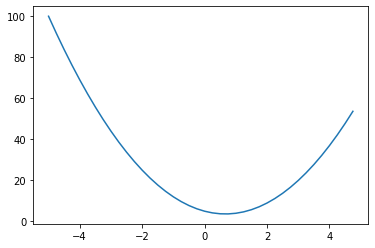

In [7]:
plt.plot(x, y)

In [8]:
h = 0.01
x0 = 3
df = (f(x0+h) - f(x0))/h

In [9]:
df

14.029999999999632

In [10]:
# -----------------------------------------------------------------------

In [11]:
a = 2
b = -3
c = 10
d = a*b + c

In [12]:
d

4

In [13]:
h = 0.001

# Values where we are interested to get the derivative
a = 2
b = -3
c = 10

d1 = a*b + c
a += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2 - d1)/h)

d1: 4
d2: 3.997
slope: -3.0000000000001137


In [14]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None # We want to chain how the outputs gradients chain to the inoput ones
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # To do operations with scalars
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1*out.grad # The 1 is for being an addition
            other.grad += 1*out.grad
            
        out._backward = _backward # We want this characteristic of out variable out to be set to the function
        # that propagates the gradient of the SUM of variables self and other
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only asserting int/float powers for now'
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
            
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other): # self / other
        return self * (other**(-1))
    
    def __neg__(self):
        return self*(-1)
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other): # To be able to do 2+a, not only a+2
        return self + other
    
    def __rmul__(self, other): # To be able to do 2*a, not only a*2
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1-(t**2)) * out.grad
        
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += math.exp(x) * out.grad
        
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        
        for node in reversed(topo):
            node._backward()

In [15]:
a = Value(2, label='a')
b = Value(-3,label='b')
c = Value(10, label='c')

In [16]:
a

Value(data=2)

In [17]:
a + b

Value(data=-1)

In [18]:
e = a*b; e.label='e'
e

Value(data=-6)

In [19]:
# Finally
d = e + c; d.label='d'
d
#(a.__mul__(b)).__add__(c) #same

Value(data=4)

In [20]:
# -----------------------------------------------------------------------

In [21]:
d._prev # Value of a*b and value of c, childrens of d
d._op

'+'

In [22]:
# To visualize better

In [23]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

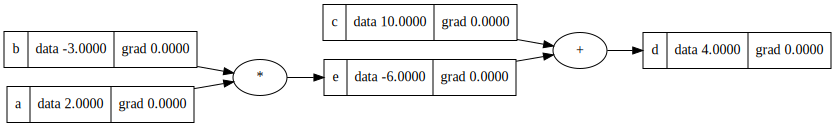

In [24]:
draw_dot(d)

In [25]:
# We exten the depth
f = Value(-2, label='f')
# L is output of our graph
L = d*f; L.label='L'

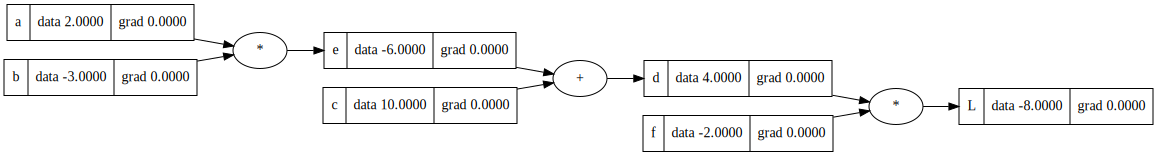

In [26]:
draw_dot(L)

In [27]:
# -----------------------------------------------------------------------

In [28]:
# Now we want to run backpropagation
def lol():
    h = 0.001
    
    a = Value(2, label='a')
    b = Value(-3,label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2, label='f')
    L = d*f; L.label='L'
    L1 = L.data
    
    a = Value(2, label='a')
    b = Value(-3,label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    
    print((L2 - L1)/h)

In [29]:
lol()

0.0


In [30]:
# We can compute the derivatiev manually
L.grad = 1
d.grad = -2
f.grad = 4

In [31]:
# Important step: gradient over layer
# We want to know dL/dc = dL/dd * dd/dc by chain rule
# In the end waht a plus node does is routing the gradient: dL/dc = (local)grad(c)*(local)grad(d)
c.grad = -2
e.grad = -2 #(-2) is the value of f, we set it manually
# We can verify all these grad claims with the lol function

In [32]:
# Similarly
a.grad = 6
b.grad = -4

In [33]:
# -----------------------------------------------------------------------

In [34]:
# We want to see how we can affect L, adding value to variables in favour of the gradient
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad

e = a*b
d = e + c
L = d*f

print(L.data)

-7.286496


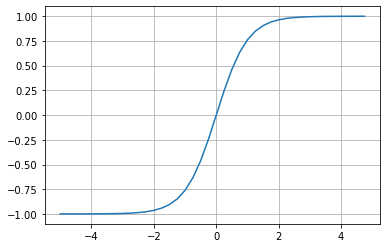

In [35]:
# Now we want to backpropagate through a neuron
plt.plot(x, np.tanh(x)); plt.grid()

In [36]:
# inputs
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')
b = Value(6.8813, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'

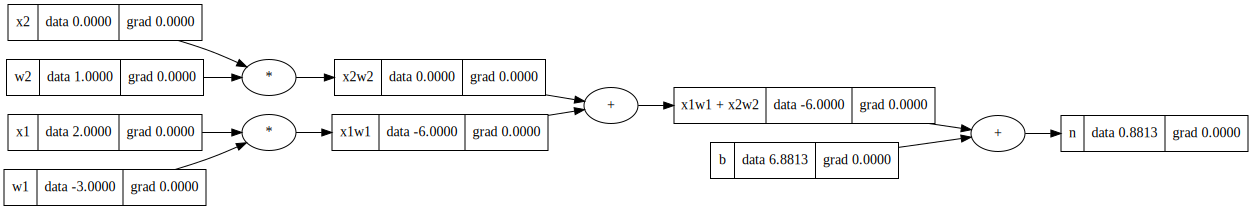

In [37]:
draw_dot(n)

In [38]:
# output
o = n.tanh(); o.label='o'

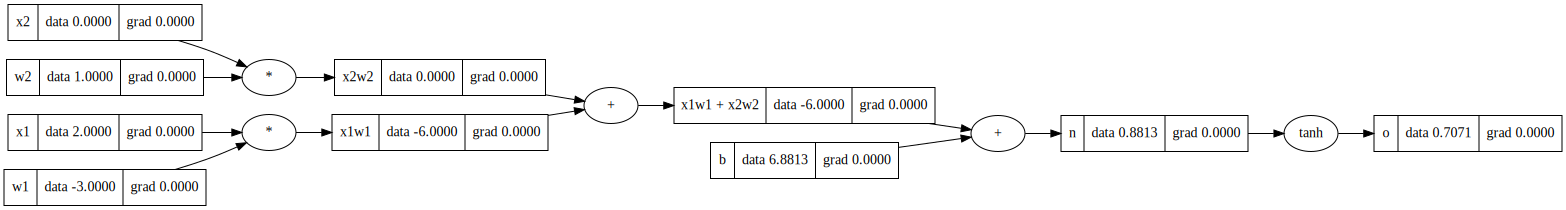

In [39]:
draw_dot(o)

In [40]:
# We start with the backpropagation
o.grad = 1
# The derivative of tanh is 1-tanh**2 (1-o.data**2), which is 0.5 in our case
n.grad = 0.5
# By chain rule
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

In [41]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [42]:
# -----------------------------------------------------------------------

In [43]:
# We start automatizing the backpropagation
# inputs
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')
b = Value(6.8813, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
# output
o = n.tanh(); o.label='o'

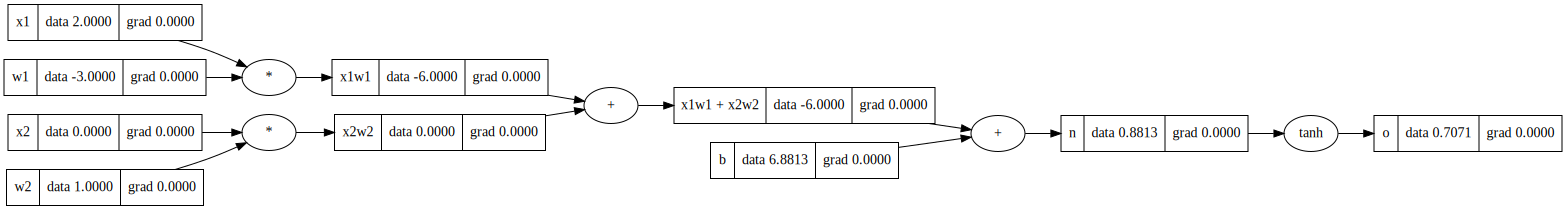

In [44]:
draw_dot(o)

In [45]:
o.grad = 1
o._backward()

In [46]:
n._backward()

In [47]:
b._backward() # It has not backward, it returns None
x1w1x2w2._backward()

In [48]:
x1w1._backward()
x2w2._backward()

In [49]:
# Now we will finally get rid of asking manually the backwards propagation
o.grad = 1

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()
    
# And we finally add it into the Value class

In [50]:
# -----------------------------------------------------------------------

In [51]:
# We start automatizing the backpropagation
# inputs
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')
b = Value(6.8813, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
# output
o = n.tanh(); o.label='o'

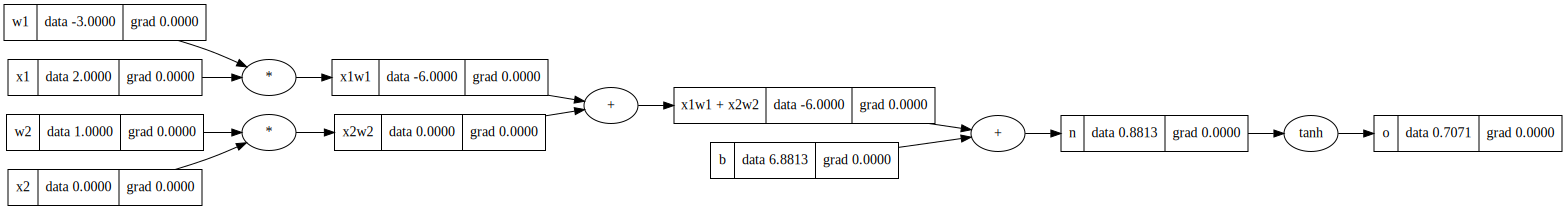

In [52]:
draw_dot(o)

In [53]:
o.backward()

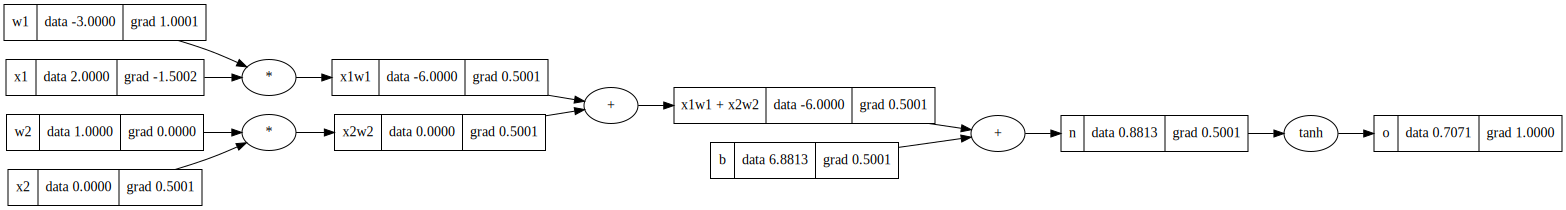

In [54]:
draw_dot(o)

In [55]:
# -----------------------------------------------------------------------

In [56]:
# We may also tweek a bit the code to be able to do operations with scalars
a = Value(2)
a*2

Value(data=4)

In [57]:
# Division as well
b = Value(3)
a/b

Value(data=0.6666666666666666)

In [58]:
# And subtraction
a-b

Value(data=-1)

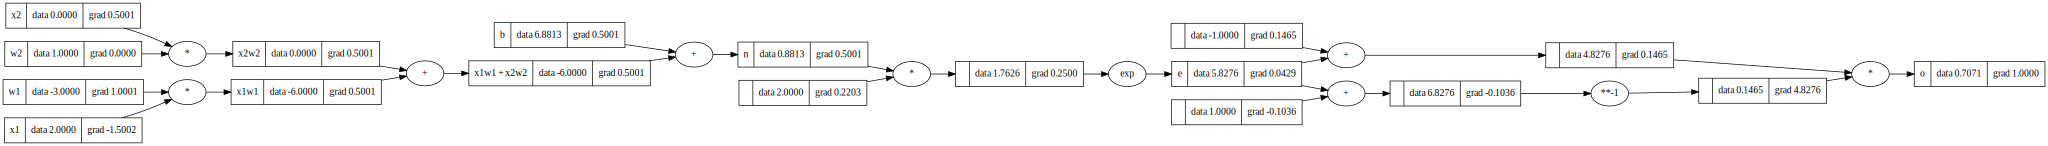

In [59]:
# We want to define the tanh more generally
# inputs
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')
b = Value(6.8813, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
# output
# --------------
e = (2*n).exp(); e.label='e'
o = (e-1)/(e+1); o.label='o'
# --------------
o.backward()
draw_dot(o)

In [60]:
# -----------------------------------------------------------------------

In [61]:
# It turns out that we can do the exact same thing using a moder library such as pytorch
import torch

In [62]:
# We can see that pytorch agrees with us
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [63]:
# -----------------------------------------------------------------------

In [64]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)] #weights
        self.b = Value(np.random.uniform(-1, 1)) #bias
    
    def __call__(self, x): # allows us to do n(x), n being a neuron
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer: #list of neurons
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        '''
        params = []
        for neurons in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
        '''

class MLP: #Multi Layer Perceptron, collection of layers
    def __init__(self, nin, nouts): # number of inputs but different number of neurons in each layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x): # sequential calling
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [65]:
x = [2, 3]
n = Neuron(2)
n(x)

Value(data=-0.07702541784165613)

In [66]:
n = Layer(2, 3)
n(x)

[Value(data=0.32759478223318683),
 Value(data=-0.9308730306620128),
 Value(data=0.9997919784339899)]

In [67]:
x = [2, 3, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.3542239759193931)

In [68]:
n.parameters() # 41 parameters

[Value(data=-0.5529360537538182),
 Value(data=0.9834708958656115),
 Value(data=-0.49461964412627424),
 Value(data=-0.39085080411534423),
 Value(data=0.4233029195011093),
 Value(data=-0.034983047849793),
 Value(data=0.21580569496926105),
 Value(data=-0.5808831384455897),
 Value(data=-0.6114998124010056),
 Value(data=0.7921646507944864),
 Value(data=0.24757855075996504),
 Value(data=-0.0911421716502443),
 Value(data=0.10340938570102387),
 Value(data=0.21776748090390075),
 Value(data=-0.16532404225280928),
 Value(data=-0.9060574267362393),
 Value(data=-0.694913193949193),
 Value(data=0.2927074099819429),
 Value(data=0.36727680661853324),
 Value(data=0.47232379758922205),
 Value(data=-0.49977561173645824),
 Value(data=0.9812618865287568),
 Value(data=-0.12528311336452425),
 Value(data=0.26737023309172403),
 Value(data=-0.3457849181259889),
 Value(data=-0.9261679030785135),
 Value(data=-0.49891037572159647),
 Value(data=-0.7896872554962022),
 Value(data=-0.11760026473065399),
 Value(data=-0

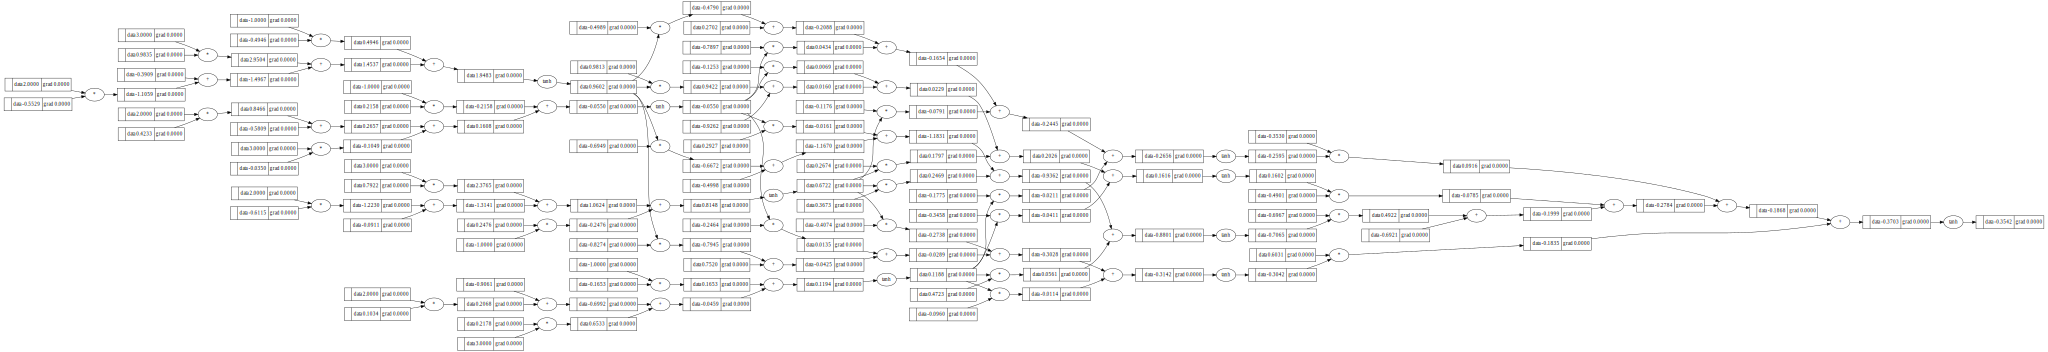

In [69]:
draw_dot(n(x))

In [70]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0], # here we aim to train the model to give 1 given the first xs list, -1 given the second...
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.3542239759193931),
 Value(data=0.3876213630389367),
 Value(data=0.15742605899479542),
 Value(data=0.18922204328754838)]

In [71]:
loss =sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.756411601248007)

In [72]:
loss.backward()

In [73]:
n.layers[0].neurons[0].w[0].data

-0.5529360537538182

In [74]:
n.layers[0].neurons[0].w[0].grad

0.7223820838475503

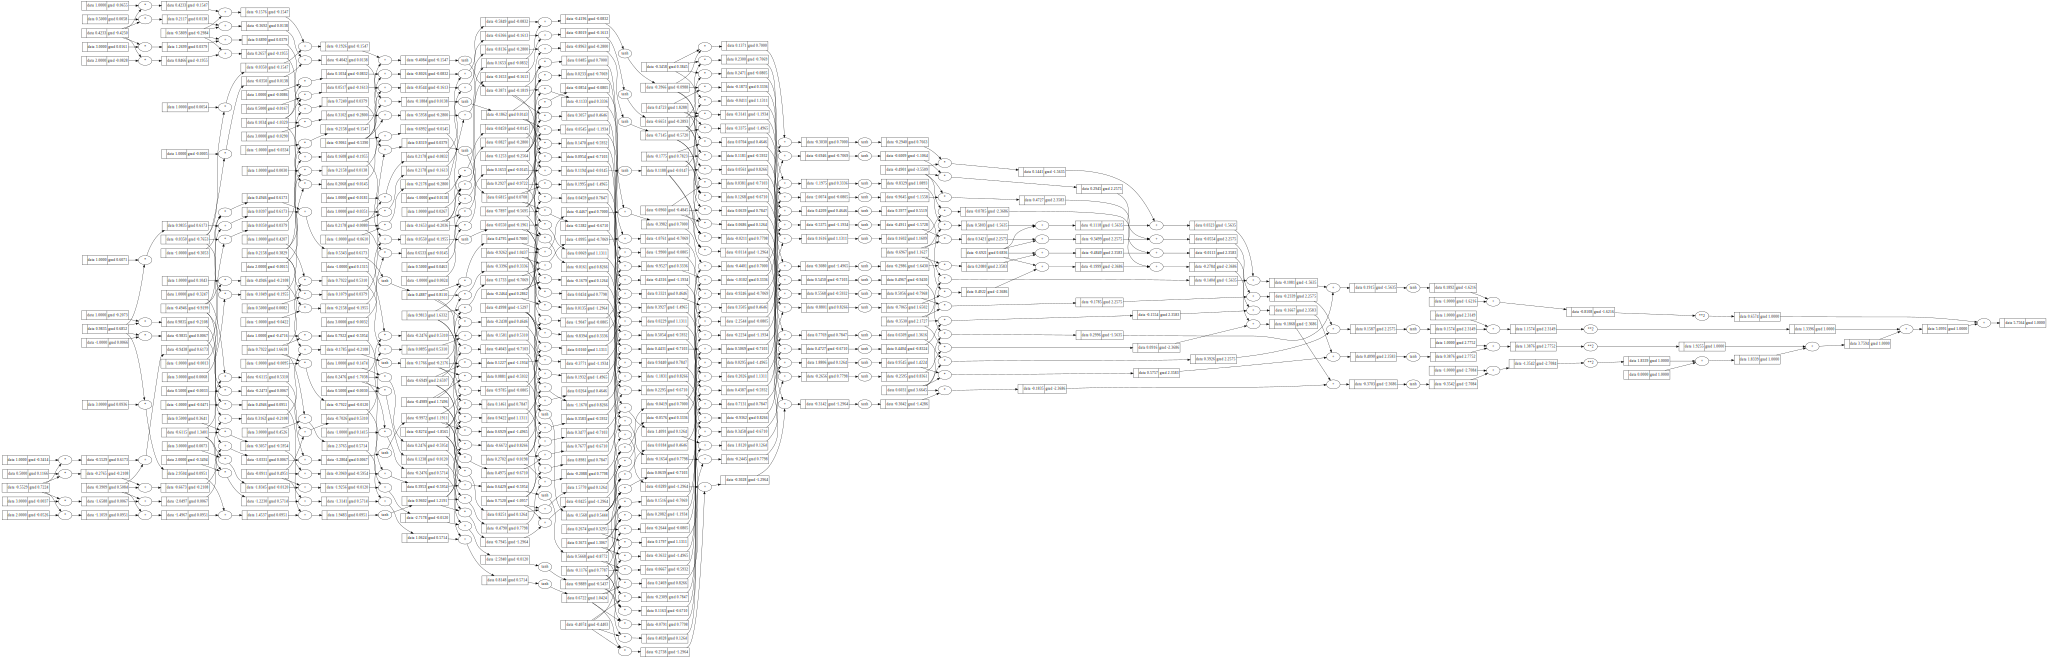

In [75]:
draw_dot(loss)

In [76]:
# -----------------------------------------------------------------------

In [77]:
# We iterate through all parameters and slightly change
for p in n.parameters():
    p.data += -0.01 * p.grad

In [78]:
# We see the data has changes a bit
n.layers[0].neurons[0].w[0].data

-0.5601598745922937

In [79]:
# We compute the loss, we see its slightly less :)
ypred = [n(x) for x in xs]
loss =sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.020873987686713)

In [80]:
# So we may iteratively reduce the loss in the following way
for p in n.parameters(): # Here we reset the old grads before backward propagating
    p.grad = 0
loss.backward()

for p in n.parameters():
    p.data += -0.01 * p.grad

ypred = [n(x) for x in xs]
loss =sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.321845732324864)

In [81]:
# When we think we are done we see ypred and compare it to the ys, to see the prediction is perfect
ypred

[Value(data=-0.17440243451548712),
 Value(data=0.11262783086939919),
 Value(data=0.03021869822863194),
 Value(data=0.19791933203453912)]

In [82]:
# The desired set of weights and params that give the predicted outcome given the inputs is
n.parameters()

[Value(data=-0.5669413910716605),
 Value(data=0.9691444387443278),
 Value(data=-0.48008316546079316),
 Value(data=-0.4017955876634857),
 Value(data=0.4325580918226564),
 Value(data=-0.019492012018244815),
 Value(data=0.20800639438127172),
 Value(data=-0.5745273086905326),
 Value(data=-0.6384369139582641),
 Value(data=0.7582455247341285),
 Value(data=0.2806995498916084),
 Value(data=-0.10110834181922566),
 Value(data=0.12492249006934665),
 Value(data=0.21830555309146174),
 Value(data=-0.16135210156772067),
 Value(data=-0.8949653533706822),
 Value(data=-0.7488750068320033),
 Value(data=0.3125420966626347),
 Value(data=0.34097780539599315),
 Value(data=0.435292753514424),
 Value(data=-0.4682434906473561),
 Value(data=0.9500469907358366),
 Value(data=-0.12082748908794418),
 Value(data=0.2615466465569824),
 Value(data=-0.3533370474064946),
 Value(data=-0.9464604785376889),
 Value(data=-0.5343311201884812),
 Value(data=-0.7783914959399347),
 Value(data=-0.13274040780432045),
 Value(data=-0.1